In [ ]:

# Auto-reload external modules when their source changes
%load_ext autoreload
%autoreload 2


import utils.helpers as helpers

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import timm
import cv2  
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json
from tqdm import tqdm

import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Path variables
BASE_PATH = "src/inputs/"
TRAIN_PATH = BASE_PATH + "train.csv"
TEST_PATH = BASE_PATH + "test.csv"




c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
helpers.set_seeds(999)

In [ ]:
BATCH_SIZE = 32  
N_FOLDS = 10
EPOCHS = 10
LR = 1e-5 
IMAGE_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# GPU Check
print(f"Using device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("WARNING: CUDA not available, using CPU!")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060
GPU Memory: 12.00 GB


In [5]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

glove_model = load_glove_model(BASE_PATH+"glove.6B.50d.txt")

Loading Glove Model
400000 words loaded!


In [6]:
train_df = pd.read_csv(BASE_PATH + "train.csv")
test_df =  pd.read_csv(BASE_PATH + "test.csv")


In [7]:
train_df['path'] = train_df['Id'].map(lambda x:str(BASE_PATH+'train/'+x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,0,1,1,0,0,0,0,0,0,0,1,50,src/inputs/train/ebaaa8e384b3d2f0a56c7ff7675c1...
1,0,1,1,1,0,1,0,1,0,0,1,0,25,src/inputs/train/25e3bf4267c2dc3f579b779418221...
2,0,0,1,1,0,1,0,0,0,0,0,0,27,src/inputs/train/6548166fb3fda22b67881176397f0...
3,0,1,1,1,0,0,0,0,1,1,0,0,19,src/inputs/train/472c40116e1833555715e4774445a...
4,0,1,1,1,0,0,0,1,0,0,0,0,27,src/inputs/train/7b77e1a6d93667b575d57db83facd...


In [8]:
#normalizing 
train_df['norm_score'] = train_df['Pawpularity']/100
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,norm_score
0,0,0,1,1,0,0,0,0,0,0,0,1,50,src/inputs/train/ebaaa8e384b3d2f0a56c7ff7675c1...,0.50
1,0,1,1,1,0,1,0,1,0,0,1,0,25,src/inputs/train/25e3bf4267c2dc3f579b779418221...,0.25
2,0,0,1,1,0,1,0,0,0,0,0,0,27,src/inputs/train/6548166fb3fda22b67881176397f0...,0.27
3,0,1,1,1,0,0,0,0,1,1,0,0,19,src/inputs/train/472c40116e1833555715e4774445a...,0.19
4,0,1,1,1,0,0,0,1,0,0,0,0,27,src/inputs/train/7b77e1a6d93667b575d57db83facd...,0.27


<Axes: >

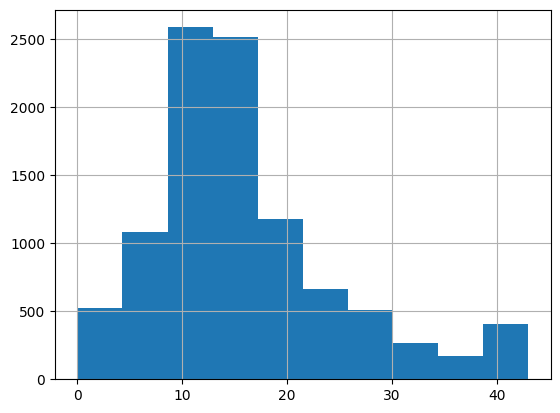

In [9]:
import numpy as np
#Sturges' rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
# num_bins
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

In [10]:

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
seed = 999
train_df['fold'] = -1

N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

In [11]:
import torch
metadata_glove = torch.zeros(12,50).cuda()
metadata_glove[0] = torch.tensor(glove_model['focus'])
metadata_glove[1] = torch.tensor(glove_model['eyes'])
metadata_glove[2] = torch.tensor(glove_model['face'])
metadata_glove[3] = torch.tensor(glove_model['near'])
metadata_glove[4] = torch.tensor(glove_model['action'])
metadata_glove[5] = torch.tensor(glove_model['accessory'])
metadata_glove[6] = torch.tensor(glove_model['group'])
metadata_glove[7] = torch.tensor(glove_model['collage'])
metadata_glove[8] = torch.tensor(glove_model['human'])
metadata_glove[9] = torch.tensor(glove_model['occlusion'])
metadata_glove[10] = torch.tensor(glove_model['info'])
metadata_glove[11] = torch.tensor(glove_model['blur'])

In [ ]:
class PetfinderDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
      
        self.paths = self.df['path'].values
        self.metadata = self.df[['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 
                                  'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 
                                  'Info', 'Blur']].values.astype(np.float32)
        self.targets = (self.df['Pawpularity'].values / 100.0).astype(np.float32)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
       
        image = cv2.imread(self.paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image=image)['image']
        
        metadata = torch.from_numpy(self.metadata[idx])
        target = torch.tensor(self.targets[idx], dtype=torch.float32)
        
        return image, metadata, target

In [13]:
def get_train_transforms():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def get_valid_transforms():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

In [ ]:
class ImprovedPawpularModel(nn.Module):
    def __init__(self, model_name='swin_large_patch4_window7_224', 
                 pretrained=True, reduction_dim=8):
        super().__init__()
        
      
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        backbone_out_dim = self.backbone.num_features
        
        # Metadata processing
        self.reduce_d = nn.Linear(50, reduction_dim)
        
        # Calculate high-order feature dimensions
        meta_first_order = 12 * reduction_dim
        meta_high_order = 12 * 12 * 3
        
        # Metadata MLP
        self.meta_mlp = nn.Sequential(
            nn.Linear(meta_first_order + meta_high_order, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Cross-attention between image and metadata 
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=128, num_heads=4, dropout=0.1, batch_first=True
        )
        
        # Image feature projection
        self.image_proj = nn.Sequential(
            nn.Linear(backbone_out_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        
        # Final fusion head
        self.head = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
        
    def forward(self, image, metadata):
        batch_size = image.size(0)
        
     
        # Process image with backbone
        img_features = self.backbone(image)
        img_features = self.image_proj(img_features)
        
        # Process metadata with GloVe embeddings
      
        embed = metadata.unsqueeze(2) * metadata_glove.unsqueeze(0)
        embed_reduce = self.reduce_d(embed)
        embed_norm = torch.norm(embed_reduce, dim=2, keepdim=True).clamp(min=1e-8)
        embed_reduce = embed_reduce / embed_norm
        
        # High-order interactions
        dot_result = torch.bmm(embed_reduce, embed_reduce.permute(0, 2, 1)).reshape(batch_size, -1)
        dot_tanh = torch.tanh(dot_result)
        dot_relu = F.relu(dot_result)
        dot_sig = torch.sigmoid(dot_result)
        
        # Combine metadata features
        meta_first_order = embed_reduce.reshape(batch_size, -1)
        meta_high_order = torch.cat([dot_tanh, dot_relu, dot_sig], dim=1)
        meta_all = torch.cat([meta_first_order, meta_high_order], dim=1)
        
        # Process metadata through MLP
        meta_features = self.meta_mlp(meta_all)
        
        # Cross-attention between metadata and image (NEW)
        img_attended, _ = self.cross_attention(
            meta_features.unsqueeze(1),
            img_features.unsqueeze(1),
            img_features.unsqueeze(1)
        )
        img_attended = img_attended.squeeze(1)
        
        # combining both image and metadata features
        fused = torch.cat([img_attended, meta_features], dim=1)
        
        # Final prediction
        output = self.head(fused)
        return output


In [15]:
# Loss and metrics - 
def rmse_loss(pred, target):
    pred = torch.sigmoid(pred.squeeze())
    return torch.sqrt(F.mse_loss(pred, target))

def calculate_rmse(pred, target):
    pred = torch.sigmoid(pred.squeeze())
    return 100 * torch.sqrt(F.mse_loss(pred, target)).item()

In [16]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [17]:
def train_epoch(model, loader, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    
    pbar = tqdm(loader, desc='Training')
    
    for batch_idx, (images, metadata, targets) in enumerate(pbar):
        # Move to device
        images = images.to(device)
        metadata = metadata.to(device)
        targets = targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = rmse_loss(outputs, targets)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'gpu_mem': f'{torch.cuda.memory_allocated(device)/1024**2:.0f}MB' if torch.cuda.is_available() else 'N/A'
        })
    
    if scheduler is not None:
        scheduler.step()
    
    return running_loss / len(loader)

In [18]:
def validate(model, loader, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, metadata, targets in tqdm(loader, desc='Validating'):
            images = images.to(device)
            metadata = metadata.to(device)
            targets = targets.to(device)
            
            outputs = model(images, metadata)
            loss = rmse_loss(outputs, targets)
            
            running_loss += loss.item()
            all_preds.append(outputs.cpu())
            all_targets.append(targets.cpu())
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    rmse = calculate_rmse(all_preds, all_targets)
    
    return running_loss / len(loader), rmse

In [ ]:
def train_fold(fold, train_df, val_df, save_dir='models'):
    Path(save_dir).mkdir(exist_ok=True)
    
    print(f"{'='*50}")
    print(f"TRAINING FOLD: {fold+1}/{N_FOLDS}")
    print(f"{'='*50}")
    
    # Datasets
    train_dataset = PetfinderDataset(train_df, transform=get_train_transforms())
    val_dataset = PetfinderDataset(val_df, transform=get_valid_transforms())
    
    print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")
    
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True,
        num_workers=0, 
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False,
        num_workers=0,  
        pin_memory=True
    )
    
    # Model
    model = ImprovedPawpularModel()
    model = model.to(DEVICE)
    
    print(f"Model on device: {next(model.parameters()).device}")
    
   
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=LR, 
        weight_decay=1e-6,
        amsgrad=False
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, eta_min=1e-7
    )
    
    early_stopping = EarlyStopping(patience=5, min_delta=0.01)
    best_rmse = float('inf')
    
    for epoch in range(1, EPOCHS + 1):
        print(f'\nEpoch {epoch}/{EPOCHS}')
        
        train_loss = train_epoch(model, train_loader, optimizer, scheduler, DEVICE)
        val_loss, val_rmse = validate(model, val_loader, DEVICE)
        
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}')
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Save best model
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_rmse': val_rmse,
                'fold': fold
            }, f'{save_dir}/model_fold_{fold}_best.pth')
            print(f' Saved best model with RMSE: {val_rmse:.4f}')
        
        early_stopping(val_rmse)
        if early_stopping.early_stop:
            print(f'Early stopping at epoch {epoch}')
            break
    
    return best_rmse


In [20]:
results = []

for fold in range(N_FOLDS):
    print(f'\n{"="*50}')
    print(f'Training Fold {fold}')
    print(f'{"="*50}')
    
    train_fold_df = train_df[train_df['fold'] != fold].reset_index(drop=True)
    val_fold_df = train_df[train_df['fold'] == fold].reset_index(drop=True)
    
    best_rmse = train_fold(fold, train_fold_df, val_fold_df)
    
    results.append({
        'fold': fold,
        'validation_rmse': best_rmse
    })
    
    print(f'\nFold {fold} - Best Validation RMSE: {best_rmse:.4f}')
    
    # Clear GPU cache between folds
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU Memory after fold: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

# Summary
print(f'\n{"="*50}')
print('Training Complete!')
print(f'{"="*50}')

for result in results:
    print(f"Fold {result['fold']}: RMSE = {result['validation_rmse']:.4f}")

avg_rmse = np.mean([r['validation_rmse'] for r in results])
print(f'\nFinal Average Validation RMSE: {avg_rmse:.4f}')

results.append({
    'fold': 'average',
    'validation_rmse': avg_rmse
})



Training Fold 0
TRAINING FOLD: 1/10
Train size: 8920, Val size: 992
Model on device: cuda:0

Epoch 1/10


Validating: 100%|██████████| 31/31 [00:19<00:00,  1.60it/s]


Train Loss: 0.2611, Val Loss: 0.2263, Val RMSE: 22.7331
 Saved best model with RMSE: 22.7331

Epoch 2/10


Validating: 100%|██████████| 31/31 [01:04<00:00,  2.08s/it]


Train Loss: 0.2370, Val Loss: 0.2161, Val RMSE: 21.7298
 Saved best model with RMSE: 21.7298

Epoch 3/10


Validating: 100%|██████████| 31/31 [01:14<00:00,  2.42s/it]


Train Loss: 0.2230, Val Loss: 0.2100, Val RMSE: 21.1255
 Saved best model with RMSE: 21.1255

Epoch 4/10


Validating: 100%|██████████| 31/31 [00:20<00:00,  1.53it/s]


Train Loss: 0.2163, Val Loss: 0.2055, Val RMSE: 20.6872
 Saved best model with RMSE: 20.6872

Epoch 5/10


Validating: 100%|██████████| 31/31 [00:24<00:00,  1.24it/s]


Train Loss: 0.2124, Val Loss: 0.2043, Val RMSE: 20.5622
 Saved best model with RMSE: 20.5622

Epoch 6/10


Validating: 100%|██████████| 31/31 [00:21<00:00,  1.42it/s]


Train Loss: 0.2054, Val Loss: 0.1917, Val RMSE: 19.3098
 Saved best model with RMSE: 19.3098

Epoch 7/10


Validating: 100%|██████████| 31/31 [00:35<00:00,  1.14s/it]


Train Loss: 0.1957, Val Loss: 0.1861, Val RMSE: 18.7432
 Saved best model with RMSE: 18.7432

Epoch 8/10


Validating: 100%|██████████| 31/31 [00:21<00:00,  1.44it/s]


Train Loss: 0.1894, Val Loss: 0.1831, Val RMSE: 18.4528
 Saved best model with RMSE: 18.4528

Epoch 9/10


Validating: 100%|██████████| 31/31 [01:05<00:00,  2.10s/it]


Train Loss: 0.1851, Val Loss: 0.1812, Val RMSE: 18.2628
 Saved best model with RMSE: 18.2628

Epoch 10/10


Validating: 100%|██████████| 31/31 [00:27<00:00,  1.12it/s]


Train Loss: 0.1850, Val Loss: 0.1807, Val RMSE: 18.2099
 Saved best model with RMSE: 18.2099

Fold 0 - Best Validation RMSE: 18.2099
GPU Memory after fold: 2.21 GB

Training Fold 1
TRAINING FOLD: 2/10
Train size: 8920, Val size: 992
Model on device: cuda:0

Epoch 1/10


Validating: 100%|██████████| 31/31 [00:21<00:00,  1.42it/s]


Train Loss: 0.2229, Val Loss: 0.2151, Val RMSE: 21.7002
 Saved best model with RMSE: 21.7002

Epoch 2/10


Validating: 100%|██████████| 31/31 [00:19<00:00,  1.60it/s]


Train Loss: 0.2106, Val Loss: 0.2005, Val RMSE: 20.2630
 Saved best model with RMSE: 20.2630

Epoch 3/10


Validating: 100%|██████████| 31/31 [00:24<00:00,  1.25it/s]


Train Loss: 0.2030, Val Loss: 0.1932, Val RMSE: 19.5525
 Saved best model with RMSE: 19.5525

Epoch 4/10


Validating: 100%|██████████| 31/31 [00:18<00:00,  1.70it/s]


Train Loss: 0.1973, Val Loss: 0.1880, Val RMSE: 19.0452
 Saved best model with RMSE: 19.0452

Epoch 5/10


Validating: 100%|██████████| 31/31 [00:26<00:00,  1.17it/s]


Train Loss: 0.1963, Val Loss: 0.1862, Val RMSE: 18.8715
 Saved best model with RMSE: 18.8715

Epoch 6/10


Validating: 100%|██████████| 31/31 [00:21<00:00,  1.41it/s]


Train Loss: 0.1938, Val Loss: 0.1821, Val RMSE: 18.4673
 Saved best model with RMSE: 18.4673

Epoch 7/10


Validating: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]


Train Loss: 0.1895, Val Loss: 0.1772, Val RMSE: 17.9791
 Saved best model with RMSE: 17.9791

Epoch 8/10


Validating: 100%|██████████| 31/31 [00:24<00:00,  1.29it/s]


Train Loss: 0.1864, Val Loss: 0.1764, Val RMSE: 17.9015
 Saved best model with RMSE: 17.9015

Epoch 9/10


Validating: 100%|██████████| 31/31 [01:05<00:00,  2.11s/it]


Train Loss: 0.1833, Val Loss: 0.1746, Val RMSE: 17.7239
 Saved best model with RMSE: 17.7239

Epoch 10/10


Validating: 100%|██████████| 31/31 [00:20<00:00,  1.52it/s]


Train Loss: 0.1816, Val Loss: 0.1732, Val RMSE: 17.5890
 Saved best model with RMSE: 17.5890

Fold 1 - Best Validation RMSE: 17.5890
GPU Memory after fold: 2.21 GB

Training Fold 2
TRAINING FOLD: 3/10
Train size: 8921, Val size: 991
Model on device: cuda:0

Epoch 1/10


Validating: 100%|██████████| 31/31 [00:25<00:00,  1.24it/s]


Train Loss: 0.2257, Val Loss: 0.2136, Val RMSE: 21.5163
 Saved best model with RMSE: 21.5163

Epoch 2/10


Validating: 100%|██████████| 31/31 [00:21<00:00,  1.42it/s]


Train Loss: 0.2148, Val Loss: 0.2057, Val RMSE: 20.7391
 Saved best model with RMSE: 20.7391

Epoch 3/10


Validating: 100%|██████████| 31/31 [00:19<00:00,  1.58it/s]


Train Loss: 0.2085, Val Loss: 0.1948, Val RMSE: 19.6649
 Saved best model with RMSE: 19.6649

Epoch 4/10


Validating: 100%|██████████| 31/31 [00:26<00:00,  1.18it/s]


Train Loss: 0.2018, Val Loss: 0.1945, Val RMSE: 19.6239
 Saved best model with RMSE: 19.6239

Epoch 5/10


Validating: 100%|██████████| 31/31 [00:23<00:00,  1.34it/s]


Train Loss: 0.2002, Val Loss: 0.1916, Val RMSE: 19.3493
 Saved best model with RMSE: 19.3493

Epoch 6/10


Validating: 100%|██████████| 31/31 [00:26<00:00,  1.19it/s]


Train Loss: 0.1971, Val Loss: 0.1839, Val RMSE: 18.5967
 Saved best model with RMSE: 18.5967

Epoch 7/10


Validating: 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]


Train Loss: 0.1919, Val Loss: 0.1808, Val RMSE: 18.2871
 Saved best model with RMSE: 18.2871

Epoch 8/10


Validating: 100%|██████████| 31/31 [00:25<00:00,  1.21it/s]


Train Loss: 0.1876, Val Loss: 0.1814, Val RMSE: 18.3455

Epoch 9/10


Validating: 100%|██████████| 31/31 [00:26<00:00,  1.18it/s]


Train Loss: 0.1854, Val Loss: 0.1794, Val RMSE: 18.1419
 Saved best model with RMSE: 18.1419

Epoch 10/10


Validating: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]


Train Loss: 0.1825, Val Loss: 0.1801, Val RMSE: 18.2092

Fold 2 - Best Validation RMSE: 18.1419
GPU Memory after fold: 0.02 GB

Training Fold 3
TRAINING FOLD: 4/10
Train size: 8921, Val size: 991
Model on device: cuda:0

Epoch 1/10


Validating: 100%|██████████| 31/31 [01:05<00:00,  2.11s/it]


Train Loss: 0.2524, Val Loss: 0.2303, Val RMSE: 23.1194
 Saved best model with RMSE: 23.1194

Epoch 2/10


Validating: 100%|██████████| 31/31 [00:22<00:00,  1.40it/s]


Train Loss: 0.2292, Val Loss: 0.2138, Val RMSE: 21.5038
 Saved best model with RMSE: 21.5038

Epoch 3/10


Validating: 100%|██████████| 31/31 [00:27<00:00,  1.14it/s]


Train Loss: 0.2172, Val Loss: 0.2034, Val RMSE: 20.4841
 Saved best model with RMSE: 20.4841

Epoch 4/10


Validating: 100%|██████████| 31/31 [00:24<00:00,  1.29it/s]


Train Loss: 0.2102, Val Loss: 0.1992, Val RMSE: 20.0704
 Saved best model with RMSE: 20.0704

Epoch 5/10


Validating: 100%|██████████| 31/31 [00:35<00:00,  1.14s/it]


Train Loss: 0.2077, Val Loss: 0.1969, Val RMSE: 19.8537
 Saved best model with RMSE: 19.8537

Epoch 6/10


Validating: 100%|██████████| 31/31 [00:24<00:00,  1.26it/s]


Train Loss: 0.2009, Val Loss: 0.1856, Val RMSE: 18.7471
 Saved best model with RMSE: 18.7471

Epoch 7/10


Validating: 100%|██████████| 31/31 [00:21<00:00,  1.44it/s]


Train Loss: 0.1937, Val Loss: 0.1785, Val RMSE: 18.0485
 Saved best model with RMSE: 18.0485

Epoch 8/10


Validating: 100%|██████████| 31/31 [00:24<00:00,  1.25it/s]


Train Loss: 0.1893, Val Loss: 0.1762, Val RMSE: 17.8191
 Saved best model with RMSE: 17.8191

Epoch 9/10


Validating: 100%|██████████| 31/31 [00:33<00:00,  1.07s/it]


Train Loss: 0.1874, Val Loss: 0.1756, Val RMSE: 17.7733
 Saved best model with RMSE: 17.7733

Epoch 10/10


Validating: 100%|██████████| 31/31 [00:28<00:00,  1.09it/s]


Train Loss: 0.1847, Val Loss: 0.1750, Val RMSE: 17.7024
 Saved best model with RMSE: 17.7024

Fold 3 - Best Validation RMSE: 17.7024
GPU Memory after fold: 2.21 GB

Training Fold 4
TRAINING FOLD: 5/10
Train size: 8921, Val size: 991
Model on device: cuda:0

Epoch 1/10


Validating: 100%|██████████| 31/31 [00:24<00:00,  1.25it/s]


Train Loss: 0.2627, Val Loss: 0.2396, Val RMSE: 24.0454
 Saved best model with RMSE: 24.0454

Epoch 2/10


Validating: 100%|██████████| 31/31 [00:23<00:00,  1.35it/s]


Train Loss: 0.2375, Val Loss: 0.2227, Val RMSE: 22.3834
 Saved best model with RMSE: 22.3834

Epoch 3/10


Validating: 100%|██████████| 31/31 [00:51<00:00,  1.68s/it]


Train Loss: 0.2214, Val Loss: 0.2098, Val RMSE: 21.1011
 Saved best model with RMSE: 21.1011

Epoch 4/10


Validating: 100%|██████████| 31/31 [00:24<00:00,  1.28it/s]


Train Loss: 0.2133, Val Loss: 0.2053, Val RMSE: 20.6571
 Saved best model with RMSE: 20.6571

Epoch 5/10


Validating: 100%|██████████| 31/31 [00:48<00:00,  1.56s/it]


Train Loss: 0.2102, Val Loss: 0.2045, Val RMSE: 20.5771
 Saved best model with RMSE: 20.5771

Epoch 6/10


Validating: 100%|██████████| 31/31 [00:23<00:00,  1.32it/s]


Train Loss: 0.2043, Val Loss: 0.1927, Val RMSE: 19.4392
 Saved best model with RMSE: 19.4392

Epoch 7/10


Validating: 100%|██████████| 31/31 [00:23<00:00,  1.31it/s]


Train Loss: 0.1948, Val Loss: 0.1855, Val RMSE: 18.7428
 Saved best model with RMSE: 18.7428

Epoch 8/10


Validating: 100%|██████████| 31/31 [00:26<00:00,  1.17it/s]


Train Loss: 0.1898, Val Loss: 0.1821, Val RMSE: 18.4133
 Saved best model with RMSE: 18.4133

Epoch 9/10


Validating: 100%|██████████| 31/31 [00:20<00:00,  1.48it/s]


Train Loss: 0.1873, Val Loss: 0.1819, Val RMSE: 18.3937
 Saved best model with RMSE: 18.3937

Epoch 10/10


Validating: 100%|██████████| 31/31 [00:23<00:00,  1.32it/s]


Train Loss: 0.1855, Val Loss: 0.1822, Val RMSE: 18.4280

Fold 4 - Best Validation RMSE: 18.3937
GPU Memory after fold: 0.02 GB

Training Fold 5
TRAINING FOLD: 6/10
Train size: 8921, Val size: 991
Model on device: cuda:0

Epoch 1/10


Validating: 100%|██████████| 31/31 [01:08<00:00,  2.21s/it]


Train Loss: 0.2184, Val Loss: 0.2093, Val RMSE: 21.0514
 Saved best model with RMSE: 21.0514

Epoch 2/10


Validating: 100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


Train Loss: 0.2096, Val Loss: 0.1986, Val RMSE: 20.0002
 Saved best model with RMSE: 20.0002

Epoch 3/10


Validating: 100%|██████████| 31/31 [00:26<00:00,  1.15it/s]


Train Loss: 0.2035, Val Loss: 0.1919, Val RMSE: 19.3354
 Saved best model with RMSE: 19.3354

Epoch 4/10


Validating: 100%|██████████| 31/31 [00:22<00:00,  1.35it/s]


Train Loss: 0.1980, Val Loss: 0.1876, Val RMSE: 18.9148
 Saved best model with RMSE: 18.9148

Epoch 5/10


Validating: 100%|██████████| 31/31 [00:24<00:00,  1.25it/s]


Train Loss: 0.1963, Val Loss: 0.1863, Val RMSE: 18.7878
 Saved best model with RMSE: 18.7878

Epoch 6/10


Validating: 100%|██████████| 31/31 [00:22<00:00,  1.35it/s]


Train Loss: 0.1939, Val Loss: 0.1818, Val RMSE: 18.3619
 Saved best model with RMSE: 18.3619

Epoch 7/10


Validating: 100%|██████████| 31/31 [00:35<00:00,  1.14s/it]


Train Loss: 0.1889, Val Loss: 0.1781, Val RMSE: 18.0040
 Saved best model with RMSE: 18.0040

Epoch 8/10


Validating: 100%|██████████| 31/31 [00:27<00:00,  1.12it/s]


Train Loss: 0.1865, Val Loss: 0.1778, Val RMSE: 17.9589
 Saved best model with RMSE: 17.9589

Epoch 9/10


Validating: 100%|██████████| 31/31 [00:40<00:00,  1.32s/it]


Train Loss: 0.1829, Val Loss: 0.1744, Val RMSE: 17.6688
 Saved best model with RMSE: 17.6688

Epoch 10/10


Validating: 100%|██████████| 31/31 [00:26<00:00,  1.15it/s]


Train Loss: 0.1805, Val Loss: 0.1752, Val RMSE: 17.7374

Fold 5 - Best Validation RMSE: 17.6688
GPU Memory after fold: 2.21 GB

Training Fold 6
TRAINING FOLD: 7/10
Train size: 8921, Val size: 991
Model on device: cuda:0

Epoch 1/10


Validating: 100%|██████████| 31/31 [01:08<00:00,  2.21s/it]


Train Loss: 0.2525, Val Loss: 0.2430, Val RMSE: 24.3560
 Saved best model with RMSE: 24.3560

Epoch 2/10


Validating: 100%|██████████| 31/31 [00:25<00:00,  1.23it/s]


Train Loss: 0.2316, Val Loss: 0.2261, Val RMSE: 22.6787
 Saved best model with RMSE: 22.6787

Epoch 3/10


Validating: 100%|██████████| 31/31 [00:38<00:00,  1.23s/it]


Train Loss: 0.2175, Val Loss: 0.2146, Val RMSE: 21.5443
 Saved best model with RMSE: 21.5443

Epoch 4/10


Validating: 100%|██████████| 31/31 [00:31<00:00,  1.03s/it]


Train Loss: 0.2106, Val Loss: 0.2088, Val RMSE: 20.9663
 Saved best model with RMSE: 20.9663

Epoch 5/10


Validating: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.2063, Val Loss: 0.2055, Val RMSE: 20.6442
 Saved best model with RMSE: 20.6442

Epoch 6/10


Validating: 100%|██████████| 31/31 [00:28<00:00,  1.08it/s]


Train Loss: 0.2003, Val Loss: 0.1935, Val RMSE: 19.4706
 Saved best model with RMSE: 19.4706

Epoch 7/10


Validating: 100%|██████████| 31/31 [00:28<00:00,  1.10it/s]


Train Loss: 0.1939, Val Loss: 0.1880, Val RMSE: 18.9450
 Saved best model with RMSE: 18.9450

Epoch 8/10


Validating: 100%|██████████| 31/31 [00:25<00:00,  1.20it/s]


Train Loss: 0.1886, Val Loss: 0.1840, Val RMSE: 18.5538
 Saved best model with RMSE: 18.5538

Epoch 9/10


Validating: 100%|██████████| 31/31 [00:36<00:00,  1.19s/it]


Train Loss: 0.1870, Val Loss: 0.1843, Val RMSE: 18.5875

Epoch 10/10


Validating: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1852, Val Loss: 0.1835, Val RMSE: 18.5029
 Saved best model with RMSE: 18.5029

Fold 6 - Best Validation RMSE: 18.5029
GPU Memory after fold: 4.41 GB

Training Fold 7
TRAINING FOLD: 8/10
Train size: 8921, Val size: 991
Model on device: cuda:0

Epoch 1/10


Validating: 100%|██████████| 31/31 [02:17<00:00,  4.43s/it]


Train Loss: 0.2175, Val Loss: 0.2094, Val RMSE: 21.1718
 Saved best model with RMSE: 21.1718

Epoch 2/10


Validating: 100%|██████████| 31/31 [01:17<00:00,  2.50s/it]


Train Loss: 0.2087, Val Loss: 0.2004, Val RMSE: 20.3097
 Saved best model with RMSE: 20.3097

Epoch 3/10


Validating: 100%|██████████| 31/31 [01:46<00:00,  3.43s/it]


Train Loss: 0.2029, Val Loss: 0.1926, Val RMSE: 19.5613
 Saved best model with RMSE: 19.5613

Epoch 4/10


Validating: 100%|██████████| 31/31 [01:46<00:00,  3.44s/it]


Train Loss: 0.1983, Val Loss: 0.1886, Val RMSE: 19.1738
 Saved best model with RMSE: 19.1738

Epoch 5/10


Validating: 100%|██████████| 31/31 [01:42<00:00,  3.31s/it]


Train Loss: 0.1978, Val Loss: 0.1876, Val RMSE: 19.0696
 Saved best model with RMSE: 19.0696

Epoch 6/10


Validating: 100%|██████████| 31/31 [01:40<00:00,  3.24s/it]


Train Loss: 0.1929, Val Loss: 0.1820, Val RMSE: 18.5093
 Saved best model with RMSE: 18.5093

Epoch 7/10


Validating: 100%|██████████| 31/31 [01:36<00:00,  3.10s/it]


Train Loss: 0.1869, Val Loss: 0.1798, Val RMSE: 18.2739
 Saved best model with RMSE: 18.2739

Epoch 8/10


Validating: 100%|██████████| 31/31 [01:50<00:00,  3.57s/it]


Train Loss: 0.1849, Val Loss: 0.1780, Val RMSE: 18.1089
 Saved best model with RMSE: 18.1089

Epoch 9/10


Validating: 100%|██████████| 31/31 [01:07<00:00,  2.19s/it]


Train Loss: 0.1811, Val Loss: 0.1785, Val RMSE: 18.1310

Epoch 10/10


Validating: 100%|██████████| 31/31 [01:34<00:00,  3.05s/it]


Train Loss: 0.1799, Val Loss: 0.1764, Val RMSE: 17.9659
 Saved best model with RMSE: 17.9659

Fold 7 - Best Validation RMSE: 17.9659
GPU Memory after fold: 4.41 GB

Training Fold 8
TRAINING FOLD: 9/10
Train size: 8921, Val size: 991
Model on device: cuda:0

Epoch 1/10


Validating: 100%|██████████| 31/31 [02:09<00:00,  4.18s/it]


Train Loss: 0.2363, Val Loss: 0.2222, Val RMSE: 22.3435
 Saved best model with RMSE: 22.3435

Epoch 2/10


Validating: 100%|██████████| 31/31 [01:21<00:00,  2.64s/it]


Train Loss: 0.2192, Val Loss: 0.2030, Val RMSE: 20.4550
 Saved best model with RMSE: 20.4550

Epoch 3/10


Validating: 100%|██████████| 31/31 [01:12<00:00,  2.35s/it]


Train Loss: 0.2064, Val Loss: 0.1951, Val RMSE: 19.6771
 Saved best model with RMSE: 19.6771

Epoch 4/10


Validating: 100%|██████████| 31/31 [01:13<00:00,  2.36s/it]


Train Loss: 0.2019, Val Loss: 0.1904, Val RMSE: 19.2228
 Saved best model with RMSE: 19.2228

Epoch 5/10


Validating: 100%|██████████| 31/31 [00:58<00:00,  1.90s/it]


Train Loss: 0.1986, Val Loss: 0.1911, Val RMSE: 19.2861

Epoch 6/10


Validating: 100%|██████████| 31/31 [01:30<00:00,  2.93s/it]


Train Loss: 0.1950, Val Loss: 0.1845, Val RMSE: 18.6470
 Saved best model with RMSE: 18.6470

Epoch 7/10


Validating: 100%|██████████| 31/31 [00:59<00:00,  1.91s/it]


Train Loss: 0.1905, Val Loss: 0.1785, Val RMSE: 18.0417
 Saved best model with RMSE: 18.0417

Epoch 8/10


Validating: 100%|██████████| 31/31 [01:02<00:00,  2.01s/it]


Train Loss: 0.1873, Val Loss: 0.1787, Val RMSE: 18.0437

Epoch 9/10


Validating: 100%|██████████| 31/31 [01:05<00:00,  2.12s/it]


Train Loss: 0.1839, Val Loss: 0.1764, Val RMSE: 17.8353
 Saved best model with RMSE: 17.8353

Epoch 10/10


Validating: 100%|██████████| 31/31 [01:00<00:00,  1.96s/it]


Train Loss: 0.1814, Val Loss: 0.1774, Val RMSE: 17.9360

Fold 8 - Best Validation RMSE: 17.8353
GPU Memory after fold: 2.21 GB

Training Fold 9
TRAINING FOLD: 10/10
Train size: 8921, Val size: 991
Model on device: cuda:0

Epoch 1/10


Validating: 100%|██████████| 31/31 [01:30<00:00,  2.92s/it]


Train Loss: 0.2389, Val Loss: 0.2169, Val RMSE: 21.8304
 Saved best model with RMSE: 21.8304

Epoch 2/10


Validating: 100%|██████████| 31/31 [00:26<00:00,  1.17it/s]


Train Loss: 0.2204, Val Loss: 0.2036, Val RMSE: 20.5149
 Saved best model with RMSE: 20.5149

Epoch 3/10


Validating: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]


Train Loss: 0.2101, Val Loss: 0.1938, Val RMSE: 19.5533
 Saved best model with RMSE: 19.5533

Epoch 4/10


Validating: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.2033, Val Loss: 0.1886, Val RMSE: 19.0443
 Saved best model with RMSE: 19.0443

Epoch 5/10


Validating: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.2002, Val Loss: 0.1886, Val RMSE: 19.0378
 Saved best model with RMSE: 19.0378

Epoch 6/10


Validating: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


Train Loss: 0.1973, Val Loss: 0.1804, Val RMSE: 18.2299
 Saved best model with RMSE: 18.2299

Epoch 7/10


Validating: 100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Train Loss: 0.1912, Val Loss: 0.1759, Val RMSE: 17.7893
 Saved best model with RMSE: 17.7893

Epoch 8/10


Validating: 100%|██████████| 31/31 [00:28<00:00,  1.11it/s]


Train Loss: 0.1882, Val Loss: 0.1740, Val RMSE: 17.6190
 Saved best model with RMSE: 17.6190

Epoch 9/10


Validating: 100%|██████████| 31/31 [00:35<00:00,  1.16s/it]


Train Loss: 0.1857, Val Loss: 0.1739, Val RMSE: 17.5806
 Saved best model with RMSE: 17.5806

Epoch 10/10


Validating: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Train Loss: 0.1838, Val Loss: 0.1732, Val RMSE: 17.5257
 Saved best model with RMSE: 17.5257

Fold 9 - Best Validation RMSE: 17.5257
GPU Memory after fold: 4.41 GB

Training Complete!
Fold 0: RMSE = 18.2099
Fold 1: RMSE = 17.5890
Fold 2: RMSE = 18.1419
Fold 3: RMSE = 17.7024
Fold 4: RMSE = 18.3937
Fold 5: RMSE = 17.6688
Fold 6: RMSE = 18.5029
Fold 7: RMSE = 17.9659
Fold 8: RMSE = 17.8353
Fold 9: RMSE = 17.5257

Final Average Validation RMSE: 17.9535
